### Аппроксимация потока суммарной приходящей коротковолновой солнечной радиации по данным цифровой фотосъемки видимой полусферы небосвода

Сначала импортируем все библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.metrics import make_scorer, mean_squared_error
import itertools

In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/(y_true+(1e-8))))

### Фильтрация выбросов

In [3]:
df = pd.read_csv('./dataset_clouds2SWradiation.csv', sep=',', decimal='.', parse_dates=['photo_time', 'data time'])
df.drop(['Unnamed: 0', 'photos', 'data time', 'CG3up[W/m2]', 'CM3down[W/m2]', 'CG3down[W/m2]', 'Temp[C]'], inplace=True, axis=1)

In [4]:
p01 = df.quantile(0.01, axis=0)
p99 = df.quantile(0.99, axis=0)

In [5]:
p01, p99

(CM3up[W/m2]     -3.790787
 f0              71.099992
 f1             131.432182
 f2              97.000000
 f3               5.000000
                   ...    
 f157             0.379226
 f158             0.389394
 f159             0.398933
 f160             0.407572
 f161             0.417246
 Name: 0.01, Length: 163, dtype: float64,
 CM3up[W/m2]     641.211692
 f0              140.584802
 f1             2468.626089
 f2              255.000000
 f3               55.000000
                   ...     
 f157              0.578498
 f158              0.637228
 f159              0.721202
 f160              0.855900
 f161              0.984047
 Name: 0.99, Length: 163, dtype: float64)

In [6]:
for c in df.columns[2:]:
    if 'f' in c:
        if p01[c] == p99[c]:
            continue
        df = df[((df[c] >= p01[c]) & (df[c] <= p99[c]))]
        print(c, df.shape)

f0 (345646, 164)
f1 (339174, 164)
f2 (337862, 164)
f3 (334711, 164)
f4 (330247, 164)
f5 (324801, 164)
f6 (323787, 164)
f7 (323137, 164)
f8 (322337, 164)
f9 (320436, 164)
f10 (319846, 164)
f11 (319021, 164)
f12 (318538, 164)
f13 (317850, 164)
f14 (317738, 164)
f15 (317562, 164)
f16 (317238, 164)
f17 (317067, 164)
f18 (316902, 164)
f19 (316874, 164)
f20 (316739, 164)
f21 (316730, 164)
f22 (316721, 164)
f23 (316605, 164)
f24 (316564, 164)
f25 (316543, 164)
f26 (316530, 164)
f27 (310896, 164)
f28 (310082, 164)
f29 (309865, 164)
f30 (305673, 164)
f31 (304776, 164)
f32 (304245, 164)
f33 (302513, 164)
f34 (302312, 164)
f35 (301028, 164)
f36 (300709, 164)
f37 (298136, 164)
f38 (297398, 164)
f39 (296412, 164)
f40 (295740, 164)
f41 (295577, 164)
f42 (295364, 164)
f43 (295312, 164)
f44 (295155, 164)
f45 (294965, 164)
f46 (294886, 164)
f47 (294760, 164)
f48 (294592, 164)
f49 (294345, 164)
f50 (293998, 164)
f51 (293822, 164)
f52 (293601, 164)
f53 (292122, 164)
f54 (288809, 164)
f55 (286060, 164)
f5

In [7]:
df.head()

,photo_time,CM3up[W/m2],f0,f1,f2,f3,f4,f5,f6,f7,...,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161
39,2021-08-16 00:03:16,4.928024,75.222624,186.951271,104.0,18.0,-0.864008,-0.391264,0.0,5.0,...,0.335955,0.348418,0.361478,0.374174,0.387200,0.398534,0.411296,0.425885,0.442269,0.455762
41,2021-08-16 00:03:26,4.643715,74.643284,166.837490,100.0,17.0,-0.916546,-0.360841,1.0,6.0,...,0.336221,0.347852,0.360083,0.372446,0.385207,0.397237,0.407407,0.417444,0.428178,0.437650
42,2021-08-16 00:03:36,4.169866,73.762467,146.958340,99.0,19.0,-0.975635,-0.300557,0.0,5.0,...,0.337385,0.348285,0.358921,0.369853,0.377763,0.386171,0.395044,0.404084,0.417710,0.429807
44,2021-08-16 00:03:46,4.359406,73.564932,146.710446,99.0,21.0,-0.974221,-0.283559,0.0,5.0,...,0.338515,0.348983,0.356760,0.363107,0.371016,0.381319,0.393549,0.407175,0.420767,0.433728
46,2021-08-16 00:03:56,4.359406,73.467225,150.433003,99.0,17.0,-0.950984,-0.301594,0.0,5.0,...,0.333644,0.343001,0.352473,0.361512,0.372313,0.383413,0.395509,0.410398,0.423891,0.433130


In [7]:
df['date-hour'] = df.photo_time.apply(lambda dt: str(dt.date())+'-'+('%02d'%dt.hour))

In [8]:
feature_columns = [c for c in df.columns if c.startswith('f')]

In [9]:
df = df[df['CM3up[W/m2]'] >= 5.0]

In [11]:
df.shape

(216647, 165)

In [10]:
dates = np.unique(df['date-hour'])
dates.shape

(470,)

In [11]:
dates_train, dates_test = train_test_split(dates, test_size=0.25)

In [12]:
ytr = df[df['date-hour'].isin(dates_train)]['CM3up[W/m2]'].values
ytest = df[~df['date-hour'].isin(dates_train)]['CM3up[W/m2]'].values

In [13]:
Xtr = df[df['date-hour'].isin(dates_train)][feature_columns].values
Xtest = df[~df['date-hour'].isin(dates_train)][feature_columns].values

# Здесь нужно выбрать лучшую конфигу сеточки

In [16]:
from sklearn.neural_network import MLPRegressor

for i in range(1,70):
    model = MLPRegressor(alpha=0.001, max_iter=10*2*i, learning_rate_init=0.001, random_state = 42,
                          solver='adam',  hidden_layer_sizes=10*i ).fit(Xtr, ytr)
    ytr_pred = model.predict(Xtr)
    print('Метрики на обучающей выборке')
    print('max_iter = ',10*2*i,'hidden_layer_sizes=',10*i)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytr, ytr_pred)))
    print('MAE:\t', mean_absolute_error(ytr, ytr_pred))
    print('MAPE:\t', mape(ytr, ytr_pred))
    print('Метрики на тестовой выборке')
    ytest_pred = model.predict(Xtest)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
    print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
    print('MAPE:\t', mape(ytest, ytest_pred))
    # Коэффициент детерминации на тестовой выборке:
    print(np.square(np.corrcoef(ytest_pred, ytest)))

D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  20 hidden_layer_sizes= 10
RMSE:	 45.78660024029164
MAE:	 28.974302938414066
MAPE:	 0.5274887030882228
Метрики на тестовой выборке
RMSE:	 41.10507346732732
MAE:	 27.973028451794164
MAPE:	 0.6851855776961224


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  40 hidden_layer_sizes= 20
RMSE:	 42.7733458616948
MAE:	 27.281422271689404
MAPE:	 0.5135907281322728
Метрики на тестовой выборке
RMSE:	 39.97403793383552
MAE:	 26.83145309196886
MAPE:	 0.6263474186132838


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  60 hidden_layer_sizes= 30
RMSE:	 40.90120568769094
MAE:	 26.918356785387576
MAPE:	 0.4474764704409943
Метрики на тестовой выборке
RMSE:	 38.76037419887894
MAE:	 26.843960078663855
MAPE:	 0.5863735673692647


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  80 hidden_layer_sizes= 40
RMSE:	 38.605738167354886
MAE:	 23.786996838557464
MAPE:	 0.4491498430784459
Метрики на тестовой выборке
RMSE:	 36.58506318917931
MAE:	 24.021093960529388
MAPE:	 0.5920376551143761


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  100 hidden_layer_sizes= 50
RMSE:	 38.39266200110973
MAE:	 23.99267169846439
MAPE:	 0.4674956307357809
Метрики на тестовой выборке
RMSE:	 38.13482153096283
MAE:	 24.464658134804953
MAPE:	 0.5890191180555152


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  120 hidden_layer_sizes= 60
RMSE:	 36.89954876912721
MAE:	 23.213219494995986
MAPE:	 0.4737242895313636
Метрики на тестовой выборке
RMSE:	 37.15488628169397
MAE:	 24.177612206545327
MAPE:	 0.6202062107525333


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (140) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  140 hidden_layer_sizes= 70
RMSE:	 35.06556185962219
MAE:	 21.16157811511843
MAPE:	 0.3906416492665859
Метрики на тестовой выборке
RMSE:	 35.04952695130749
MAE:	 23.081287792061396
MAPE:	 0.536775862718107


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (160) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  160 hidden_layer_sizes= 80
RMSE:	 35.0117089608594
MAE:	 21.65668748606973
MAPE:	 0.36795222148876816
Метрики на тестовой выборке
RMSE:	 36.36066784439439
MAE:	 23.40195316765041
MAPE:	 0.5225528597719602
Метрики на обучающей выборке
max_iter =  180 hidden_layer_sizes= 90
RMSE:	 36.847102831964584
MAE:	 23.354139821911296
MAPE:	 0.41790910037309603
Метрики на тестовой выборке
RMSE:	 37.65972081531109
MAE:	 24.49467089775895
MAPE:	 0.5196823768706781


D:\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Метрики на обучающей выборке
max_iter =  200 hidden_layer_sizes= 100
RMSE:	 35.7385483487274
MAE:	 22.277774688308224
MAPE:	 0.3801810757043733
Метрики на тестовой выборке
RMSE:	 39.10534995393261
MAE:	 24.927168463634768
MAPE:	 0.5482575731999101
Метрики на обучающей выборке
max_iter =  220 hidden_layer_sizes= 110
RMSE:	 34.77481329609051
MAE:	 21.54660372448379
MAPE:	 0.3707186298198192
Метрики на тестовой выборке
RMSE:	 37.855729098413775
MAE:	 24.622264746939784
MAPE:	 0.5800634264320957
Метрики на обучающей выборке
max_iter =  240 hidden_layer_sizes= 120
RMSE:	 36.123764766067765
MAE:	 22.1978147030958
MAPE:	 0.38076019064712463
Метрики на тестовой выборке
RMSE:	 36.20086467722035
MAE:	 23.484056908425273
MAPE:	 0.552616223120651
Метрики на обучающей выборке
max_iter =  260 hidden_layer_sizes= 130
RMSE:	 33.671676804585225
MAE:	 20.93059618503394
MAPE:	 0.3466565984351714
Метрики на тестовой выборке
RMSE:	 36.00656770739808
MAE:	 23.513764911793054
MAPE:	 0.5246897639871246
Метрик

In [17]:
vmin = 5.0
vmax = max(np.percentile(ytr, 99), np.percentile(ytest, 99))
bins = np.linspace(vmin, vmax, 100, endpoint=True)

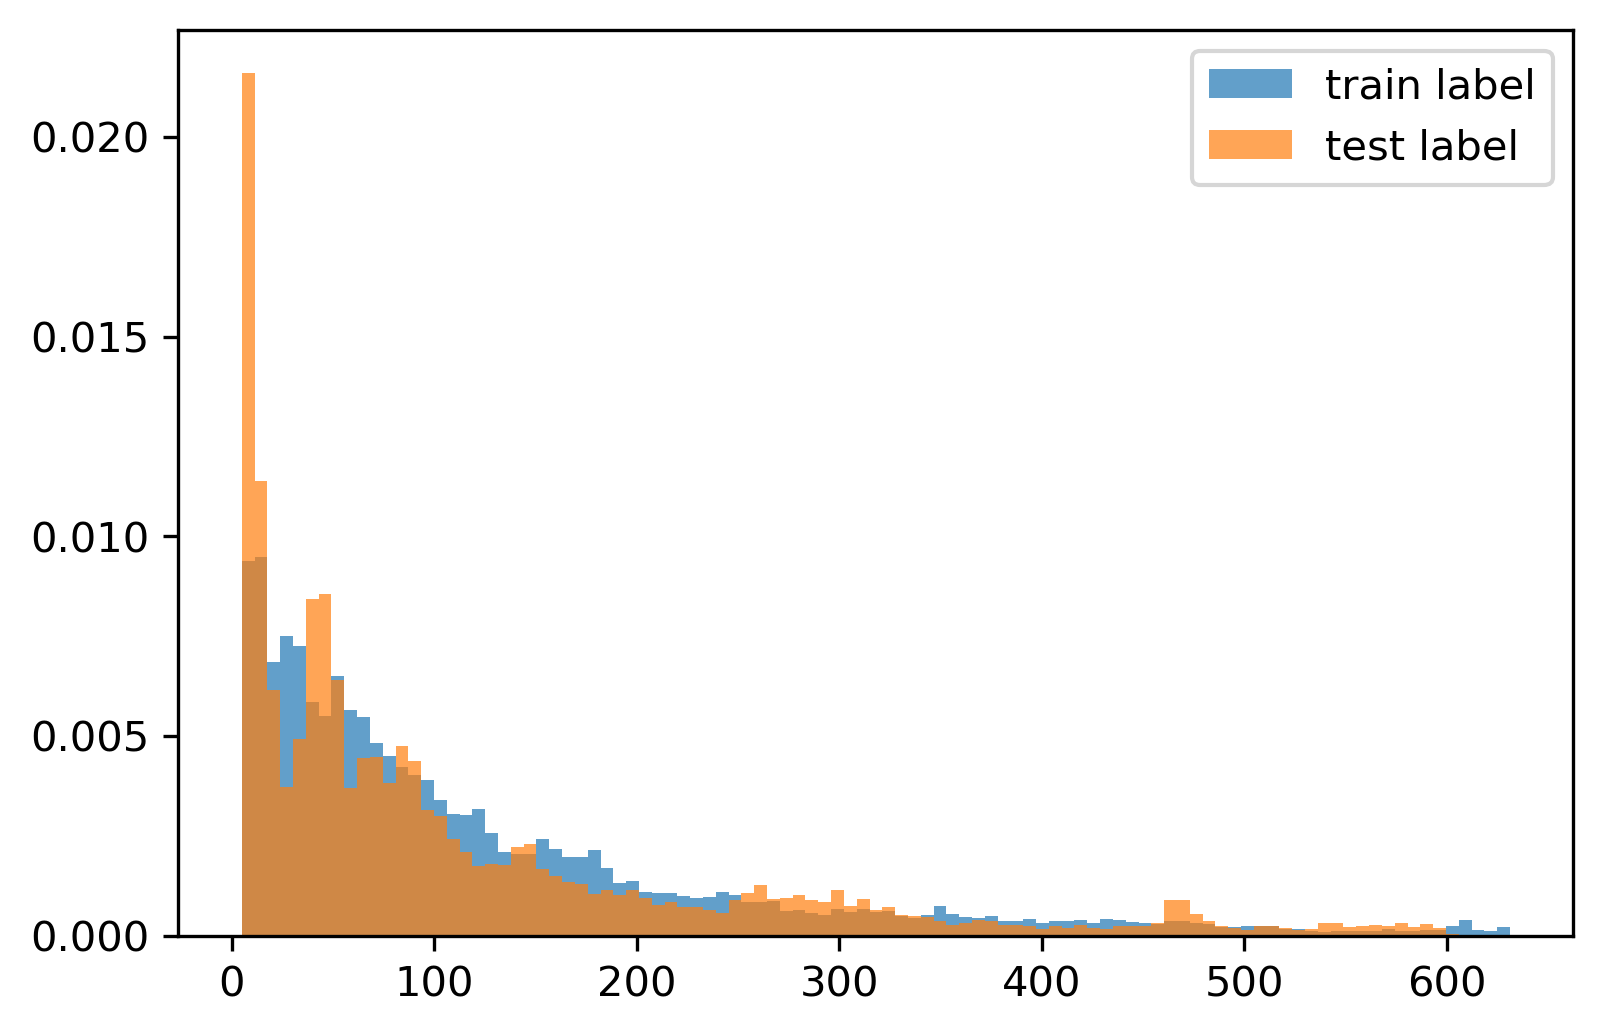

In [18]:
f = plt.figure(figsize=(6,4), dpi=300)
_ = plt.hist(ytr, bins=bins, density=True, alpha=0.7, label='train label')
_ = plt.hist(ytest, bins=bins, density=True, alpha=0.7, label='test label')
_ = plt.legend()

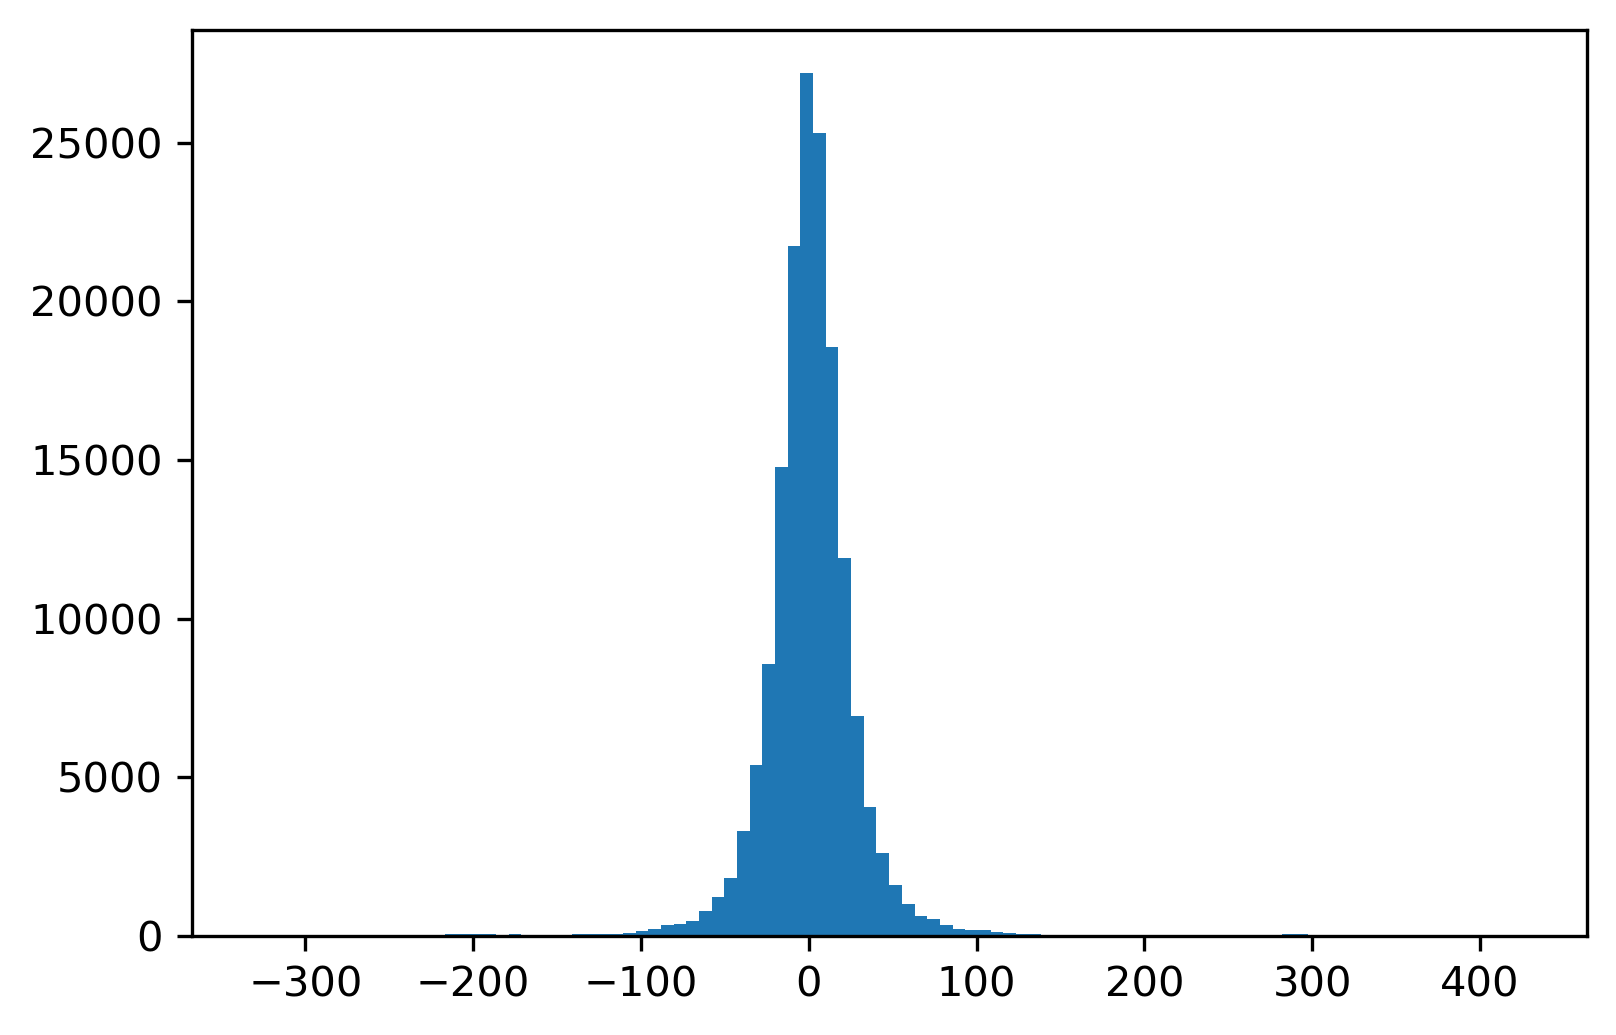

In [19]:
# Здесь посмотрим на распределение ошибок модели. Если все правильно, распределение должно быть одномодальным, похожим на нормальное.
f = plt.figure(figsize=(6,4), dpi=300)
_ = plt.hist(ytr_pred-ytr, bins=100)

In [20]:
ytest_pred = model.predict(Xtest)

In [21]:
print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
print('MAPE:\t', mape(ytest, ytest_pred))

RMSE:	 34.26064593708026
MAE:	 22.059734898682464
MAPE:	 0.5437184938229321


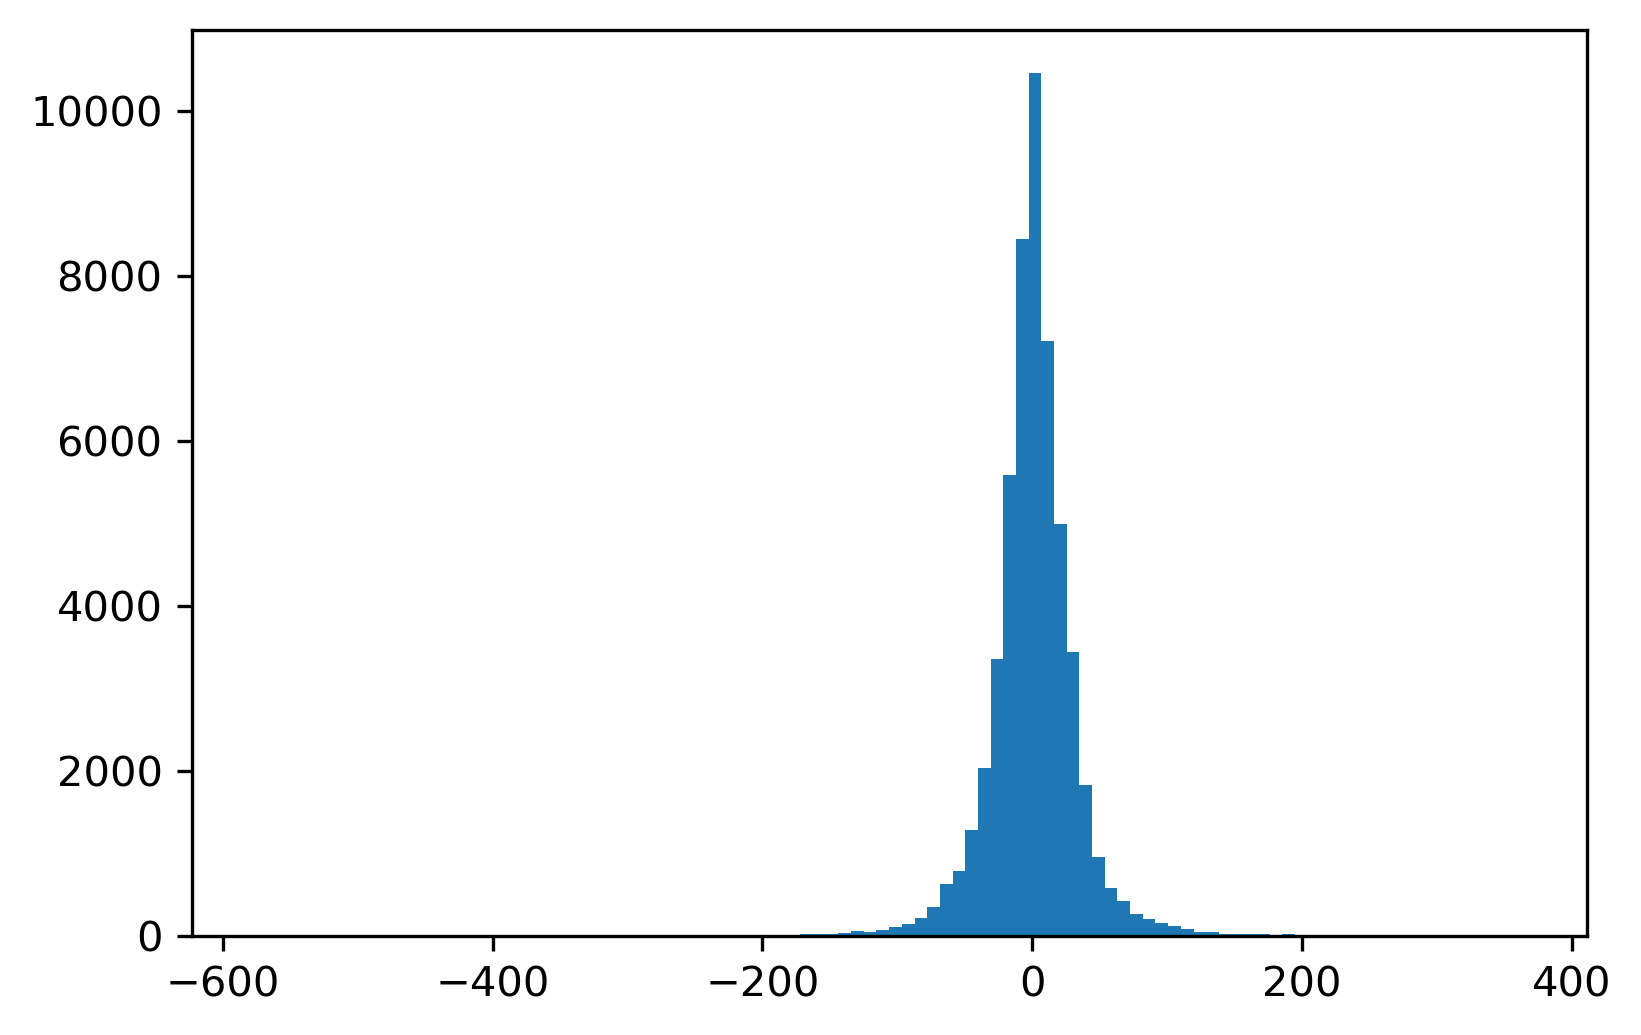

In [22]:
f = plt.figure(figsize=(6,4), dpi=300)
_ = plt.hist(ytest_pred-ytest, bins=100)

In [23]:
# Коэффициент детерминации на тестовой выборке:
np.square(np.corrcoef(ytest_pred, ytest)),model.score(Xtest, ytest)

(array([[1.        , 0.93819544],
        [0.93819544, 1.        ]]),
 0.9377057453302158)

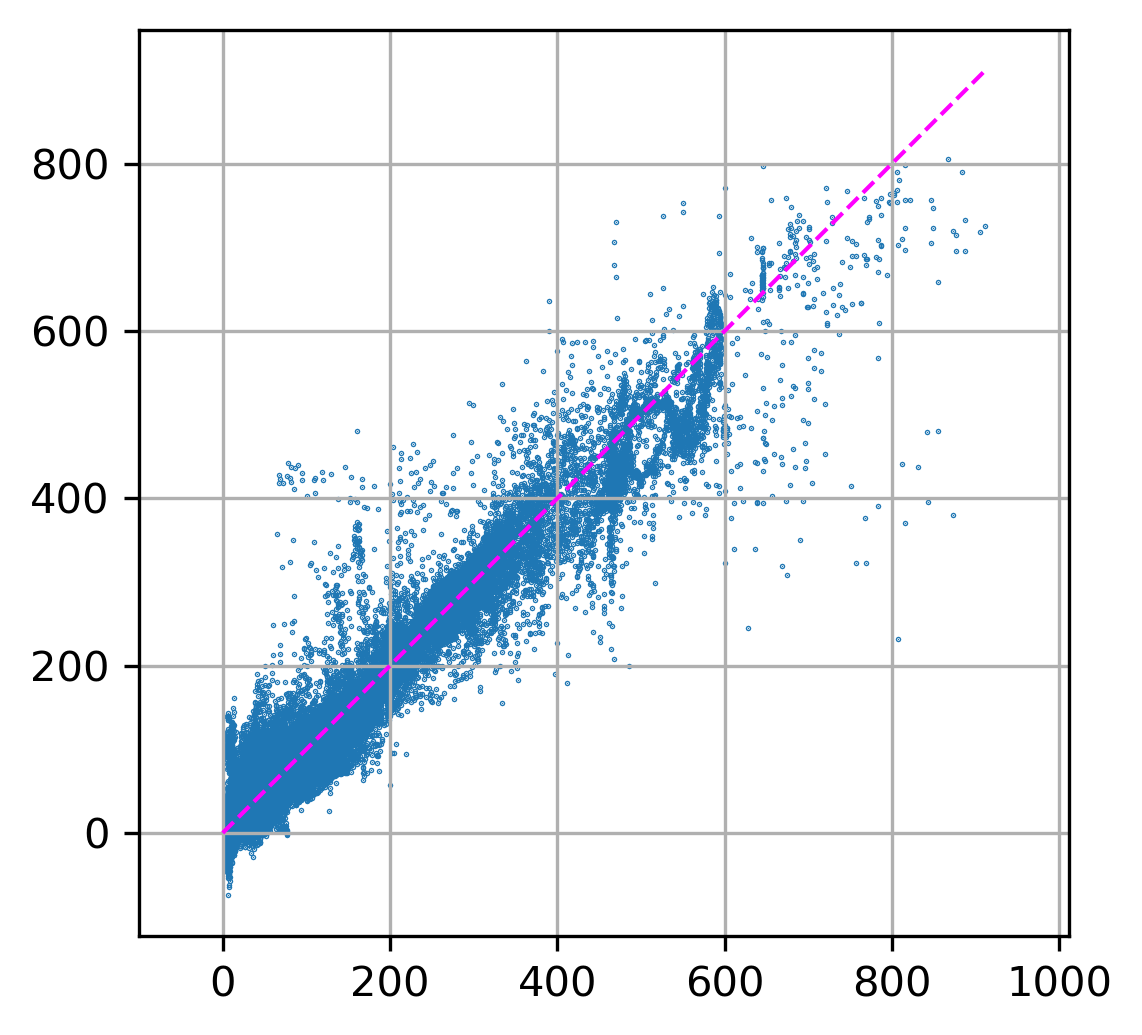

In [24]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.axis('equal')
plt.plot([0.0, max(ytest.max(), ytest_pred.max())], [0.0, max(ytest.max(), ytest_pred.max())], '--', color='magenta', linewidth=1)
plt.grid()

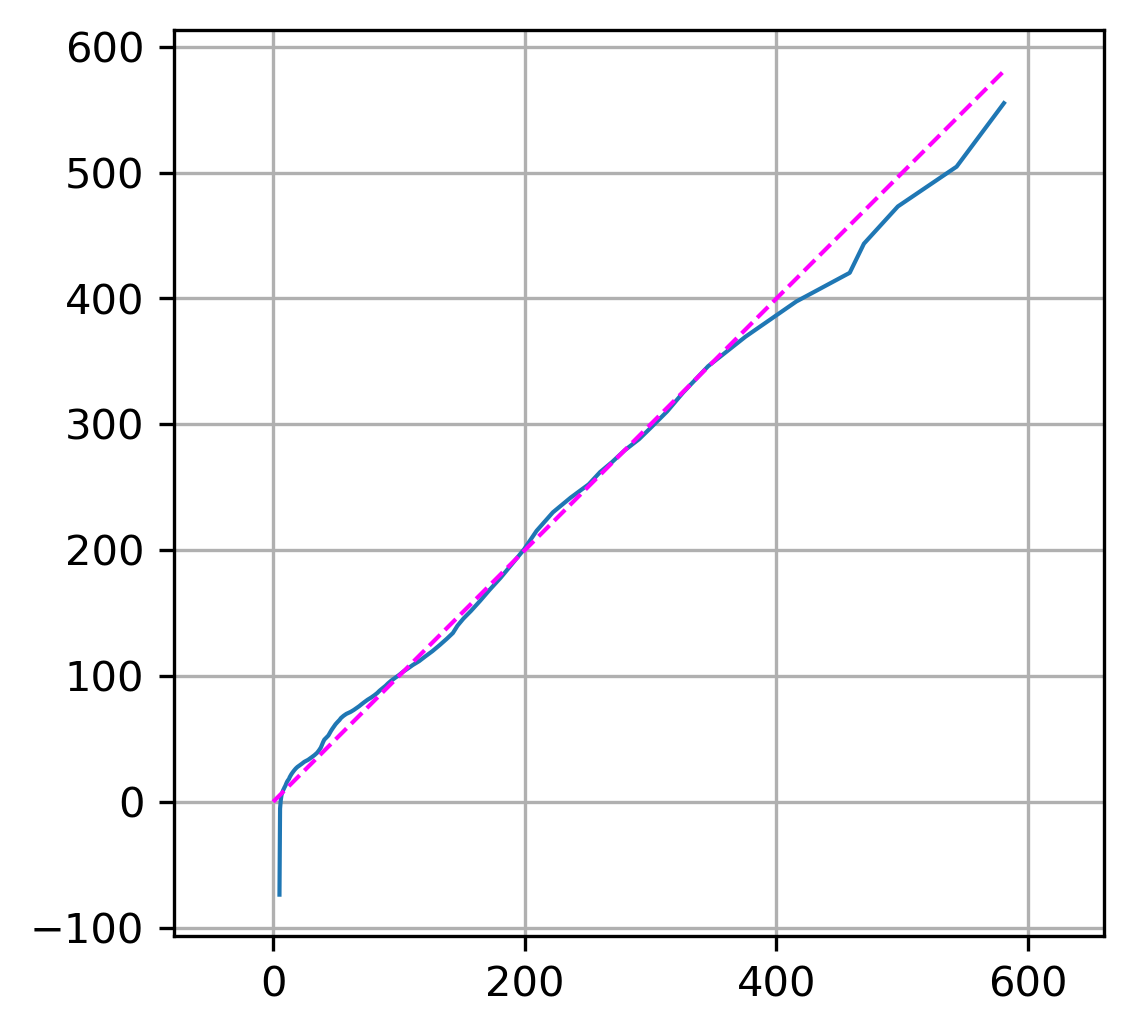

In [25]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
quantile_levels = np.arange(0, 100, 1)
ytest_quantiles = np.percentile(ytest, quantile_levels)
ytest_pred_quantiles = np.percentile(ytest_pred, quantile_levels)
f = plt.figure(figsize=(4,4), dpi=300)
plt.plot(ytest_quantiles, ytest_pred_quantiles, linewidth=1)
plt.axis('equal')
plt.plot([0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], [0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], '--', color='magenta', linewidth=1)
plt.grid()

## SVM для регрессии

In [26]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)).fit(Xtr, ytr)

In [27]:
ytr_pred = svr.predict(Xtr)
print('Метрики на обучающей выборке')
print('RMSE:\t', np.sqrt(mean_squared_error(ytr, ytr_pred)))
print('MAE:\t', mean_absolute_error(ytr, ytr_pred))
print('MAPE:\t', mape(ytr, ytr_pred))
print('Метрики на тестовой выборке')
ytest_pred = svr.predict(Xtest)
print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
print('MAPE:\t', mape(ytest, ytest_pred))
print(np.square(np.corrcoef(ytest_pred, ytest)))

Метрики на обучающей выборке
RMSE:	 49.28214508028826
MAE:	 24.658035159320082
MAPE:	 0.397916623430381
Метрики на тестовой выборке
RMSE:	 44.41888444100488
MAE:	 25.26619116779927
MAPE:	 0.5452992788724488


In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.axis('equal')
plt.plot([0.0, max(ytest.max(), ytest_pred.max())], [0.0, max(ytest.max(), ytest_pred.max())], '--', color='magenta', linewidth=1)
plt.grid()

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
quantile_levels = np.arange(0, 100, 1)
ytest_quantiles = np.percentile(ytest, quantile_levels)
ytest_pred_quantiles = np.percentile(ytest_pred, quantile_levels)
f = plt.figure(figsize=(4,4), dpi=300)
plt.plot(ytest_quantiles, ytest_pred_quantiles, linewidth=1)
plt.axis('equal')
plt.plot([0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], [0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], '--', color='magenta', linewidth=1)
plt.grid()

## LinearSVR

In [ ]:
from sklearn.svm import LinearSVR
linsvr = make_pipeline(StandardScaler(), LinearSVR(C=1.0, random_state=42, tol=1e-5)).fit(Xtr, ytr)

In [ ]:
ytr_pred = linsvr.predict(Xtr)
print('Метрики на обучающей выборке')
print('RMSE:\t', np.sqrt(mean_squared_error(ytr, ytr_pred)))
print('MAE:\t', mean_absolute_error(ytr, ytr_pred))
print('MAPE:\t', mape(ytr, ytr_pred))
print('Метрики на тестовой выборке')
ytest_pred = linsvr.predict(Xtest)
print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
print('MAPE:\t', mape(ytest, ytest_pred))
print(np.square(np.corrcoef(ytest_pred, ytest)))

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.axis('equal')
plt.plot([0.0, max(ytest.max(), ytest_pred.max())], [0.0, max(ytest.max(), ytest_pred.max())], '--', color='magenta', linewidth=1)
plt.grid()

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
quantile_levels = np.arange(0, 100, 1)
ytest_quantiles = np.percentile(ytest, quantile_levels)
ytest_pred_quantiles = np.percentile(ytest_pred, quantile_levels)
f = plt.figure(figsize=(4,4), dpi=300)
plt.plot(ytest_quantiles, ytest_pred_quantiles, linewidth=1)
plt.axis('equal')
plt.plot([0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], [0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], '--', color='magenta', linewidth=1)
plt.grid()

## HuberRegressor

In [23]:
from sklearn.linear_model import HuberRegressor

for i in range(1,50):
    huber = HuberRegressor( epsilon = 1.2 + 0.1*i , max_iter=10*2*i,  
                            ).fit(Xtr, ytr)
    ytr_pred = huber.predict(Xtr)
    print('Метрики на обучающей выборке')
    print('max_iter = ',10*2*i,'epsilon=',1.2 + 0.1*i)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytr, ytr_pred)))
    print('MAE:\t', mean_absolute_error(ytr, ytr_pred))
    print('MAPE:\t', mape(ytr, ytr_pred))
    print('Метрики на тестовой выборке')
    ytest_pred = huber.predict(Xtest)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
    print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
    print('MAPE:\t', mape(ytest, ytest_pred))
    print(np.square(np.corrcoef(ytest_pred, ytest)))

C:\Users\mechta\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Метрики на обучающей выборке
max_iter =  20 epsilon= 1.3
RMSE:	 89.58038447168393
MAE:	 49.575855353375324
MAPE:	 0.8112002612367114
Метрики на тестовой выборке
RMSE:	 101.19426532690387
MAE:	 61.46847959489276
MAPE:	 0.7719872388878698


C:\Users\mechta\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Метрики на обучающей выборке
max_iter =  40 epsilon= 1.4
RMSE:	 83.974960919666
MAE:	 46.02929280957589
MAPE:	 0.7905700491276214
Метрики на тестовой выборке
RMSE:	 97.05529186393517
MAE:	 59.71917718762552
MAPE:	 0.7998740682771308


C:\Users\mechta\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Метрики на обучающей выборке
max_iter =  60 epsilon= 1.5
RMSE:	 76.18701421133359
MAE:	 44.63363461828465
MAPE:	 0.818227580686136
Метрики на тестовой выборке
RMSE:	 88.03426202853203
MAE:	 57.50113161538805
MAPE:	 0.8570210846496427


C:\Users\mechta\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Метрики на обучающей выборке
max_iter =  80 epsilon= 1.6
RMSE:	 73.22560985859766
MAE:	 43.37631597788511
MAPE:	 0.7964124249020096
Метрики на тестовой выборке
RMSE:	 85.31927575761992
MAE:	 56.30400442654961
MAPE:	 0.8706661788054482


C:\Users\mechta\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Метрики на обучающей выборке
max_iter =  100 epsilon= 1.7
RMSE:	 68.54917070601351
MAE:	 42.455897837471056
MAPE:	 0.8132753116594077
Метрики на тестовой выборке
RMSE:	 80.27724021970964
MAE:	 53.932431136635635
MAPE:	 0.8788930178912648


KeyboardInterrupt: 

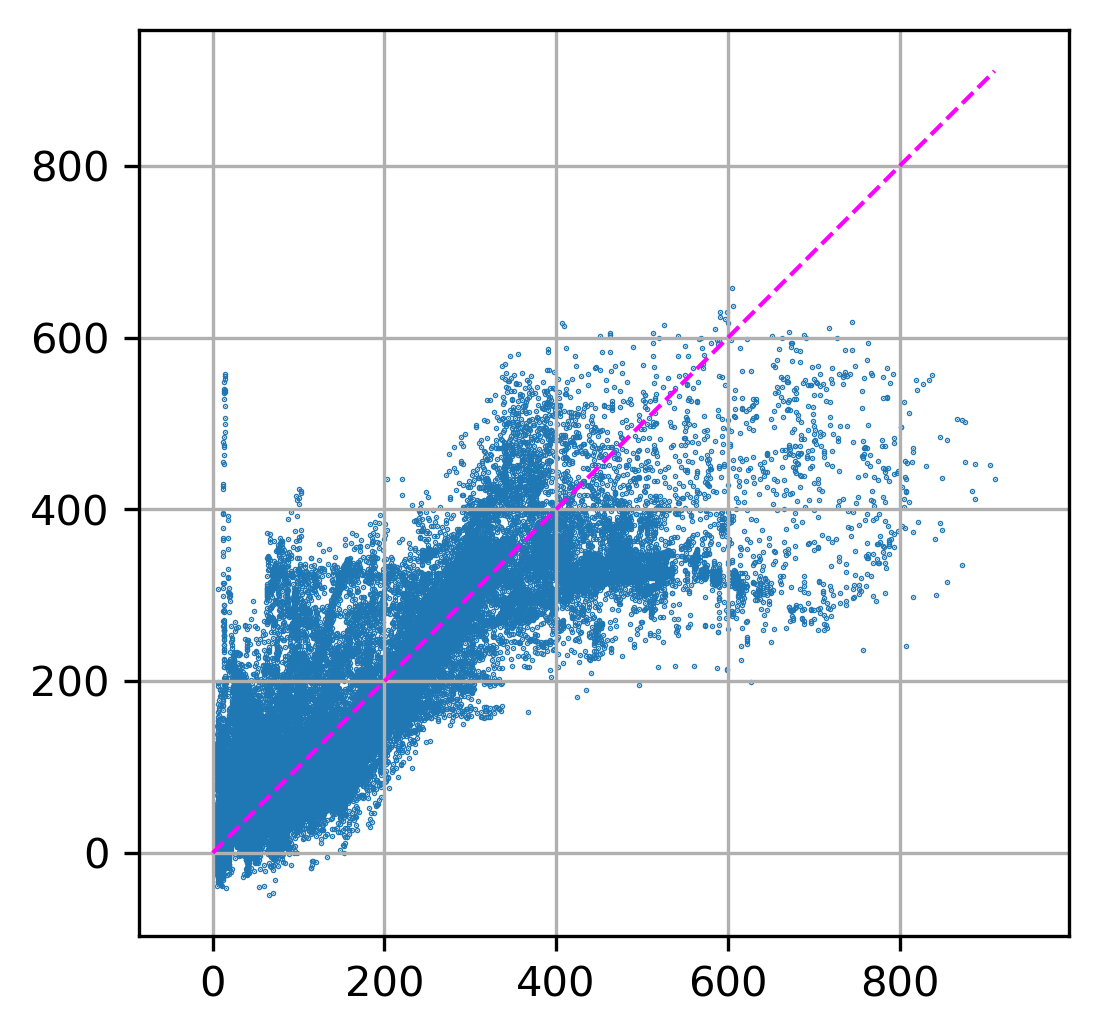

In [24]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.axis('equal')
plt.plot([0.0, max(ytest.max(), ytest_pred.max())], [0.0, max(ytest.max(), ytest_pred.max())], '--', color='magenta', linewidth=1)
plt.grid()

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
quantile_levels = np.arange(0, 100, 1)
ytest_quantiles = np.percentile(ytest, quantile_levels)
ytest_pred_quantiles = np.percentile(ytest_pred, quantile_levels)
f = plt.figure(figsize=(4,4), dpi=300)
plt.plot(ytest_quantiles, ytest_pred_quantiles, linewidth=1)
plt.axis('equal')
plt.plot([0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], [0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], '--', color='magenta', linewidth=1)
plt.grid()

## KNeighborsRegressor

In [19]:
from sklearn.neighbors import KNeighborsRegressor

for i in range(1,30):
    kn = KNeighborsRegressor(n_neighbors=2+i).fit(Xtr, ytr)                            
    ytr_pred = kn.predict(Xtr)
    print('Метрики на обучающей выборке')
    print('max_iter = ',10*2*i,'epsilon=',1.2 + i)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytr, ytr_pred)))
    print('MAE:\t', mean_absolute_error(ytr, ytr_pred))
    print('MAPE:\t', mape(ytr, ytr_pred))
    print('Метрики на тестовой выборке')
    ytest_pred = kn.predict(Xtest)
    print('RMSE:\t', np.sqrt(mean_squared_error(ytest, ytest_pred)))
    print('MAE:\t', mean_absolute_error(ytest, ytest_pred))
    print('MAPE:\t', mape(ytest, ytest_pred))
    print(np.square(np.corrcoef(ytest_pred, ytest)))

KeyboardInterrupt: 

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
f = plt.figure(figsize=(4,4), dpi=300)
plt.scatter(ytest, ytest_pred, s=0.1)
plt.axis('equal')
plt.plot([0.0, max(ytest.max(), ytest_pred.max())], [0.0, max(ytest.max(), ytest_pred.max())], '--', color='magenta', linewidth=1)
plt.grid()

In [ ]:
# Диаграмма соответствия аппроксимированных и известных значений целевой переменной на тестовой выборке
quantile_levels = np.arange(0, 100, 1)
ytest_quantiles = np.percentile(ytest, quantile_levels)
ytest_pred_quantiles = np.percentile(ytest_pred, quantile_levels)
f = plt.figure(figsize=(4,4), dpi=300)
plt.plot(ytest_quantiles, ytest_pred_quantiles, linewidth=1)
plt.axis('equal')
plt.plot([0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], [0.0, max(ytest_quantiles.max(), ytest_pred_quantiles.max())], '--', color='magenta', linewidth=1)
plt.grid()